
# Libraries



In [66]:
import numpy as np
import pandas as pd
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
from google.colab.patches import cv2_imshow
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization



# Any results you write to the current directory are saved as output

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [31]:
import os
print(os.listdir("./drive/MyDrive/CK+48"))

['happy', 'contempt', 'fear', 'surprise', 'sadness', 'anger', 'disgust']


# Extracting images from directory

In [ ]:
data_path = './drive/MyDrive/CK+48'
data_dir_list = os.listdir(data_path)

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')

# Convert the picture to double to convey informtaion
img_data = img_data/255
img_data.shape

Loaded the images of dataset-happy

Loaded the images of dataset-surprise

Loaded the images of dataset-disgust

Loaded the images of dataset-sadness

Loaded the images of dataset-fear

Loaded the images of dataset-contempt

Loaded the images of dataset-anger



(100, 48, 48, 3)

## Show examples of the import picture


## Show Examples of the Picture(Anger)

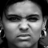

(48, 48, 3)
(48, 48, 3)


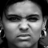

In [113]:
cv2_imshow(img_data_list[0])
print(img_data_list[0].shape)
print(img_data[0].shape)
cv2_imshow(img_data[0]*255)

# Putting label in data¶


In [73]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

# Splitting the training test

In [74]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

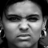

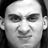

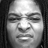

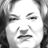

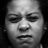

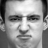

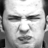

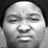

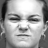

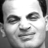

In [121]:
X_test
for i in range(10):
  cv2_imshow(img_data[i] * 255)


# Creating Model


In [77]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
    
    return model


# Model Summary

In [78]:
model_custom = create_model()
model_custom.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 48, 48, 6)         456       
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 24, 24, 16)        2416      
_________________________________________________________________
activation_64 (Activation)   (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 10, 10, 64)        9280      
_________________________________________________________________
max_pooling2d_194 (MaxPoolin (None, 5, 5, 64)        

# Model Visualization 

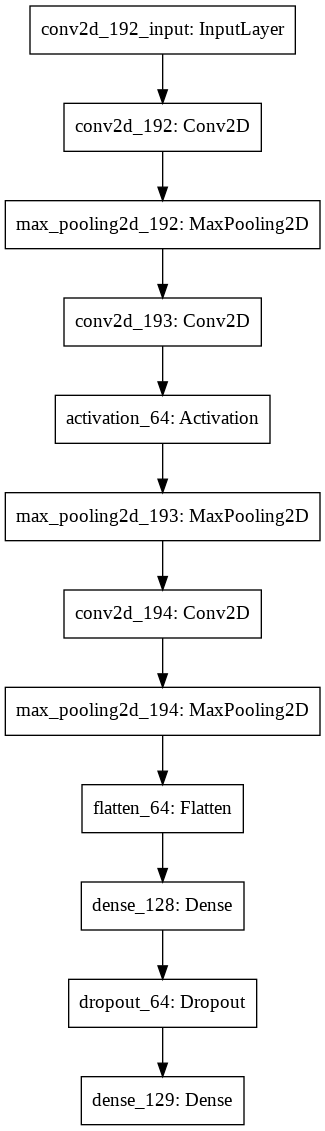

In [79]:
from keras.utils import plot_model
plot_model(model_custom, to_file='model.png')

# Conduct k-Fold Cross-Validation


In [80]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle= False)

from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# Training Model

In [98]:
BS = 8
EPOCHS = 10
if not os.path.exists("model"):
  os.makedirs("model")


In [99]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path = "./models"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]

    model = create_model()
    hist = model.fit(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=0)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    print(score)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

[2.348370344407158e-06, 1.0]
[3.576278118089249e-08, 1.0]
[2.0801812752324622e-06, 1.0]
[3.1351569305115845e-06, 1.0]
[9.267681889468804e-06, 1.0]


In [83]:
print(scores_acc,scores_loss)

[1.0, 1.0, 1.0, 1.0, 1.0] [1.7285331921357283e-07, 8.284982868644875e-07, 5.364415756048402e-08, 1.192092824453539e-08, 1.509590947534889e-05]


# Taking model with lowest Loss


In [84]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

3


In [122]:
model.load_weights("models"+str(value_index)+".hdf5")

best_model = model


# Evaluating model


In [129]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(best_model(test_image))
print(best_model.predict_classes(test_image))
print(y_test[0:1])

#predict
y_pred = best_model(test_image)
print("prediction")
print(y_pred)
print(np.argmax(y_pred, axis=1))

Test Loss: 1.76427056430839e-06
Test accuracy: 1.0
(1, 48, 48, 3)
tf.Tensor(
[[1.0000000e+00 9.3434815e-10 1.0946293e-08 8.8828050e-13 1.0423789e-12
  8.8036278e-10 3.7369308e-10]], shape=(1, 7), dtype=float32)
[0]
[[1. 0. 0. 0. 0. 0. 0.]]
prediction
tf.Tensor(
[[1.0000000e+00 9.3434815e-10 1.0946293e-08 8.8828050e-13 1.0423789e-12
  8.8036278e-10 3.7369308e-10]], shape=(1, 7), dtype=float32)
[0]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Visualization

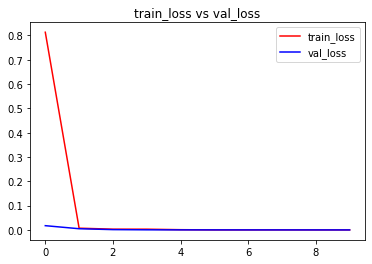

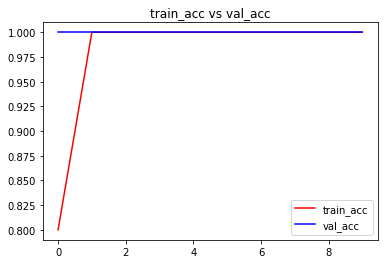

<Figure size 432x288 with 0 Axes>

In [87]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

#Model Save
best_model.save_weights('model_weights.h5')
best_model.save('model_keras.h5')

# Some sample visualization Result

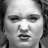

[0]


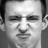

[0]


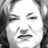

[0]


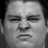

[0]


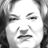

[0]


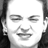

[0]


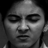

[0]


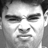

[0]


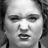

[0]


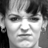

[0]


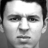

[0]


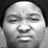

[0]


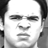

[0]


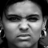

[0]


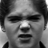

[0]


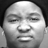

[0]


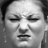

[0]


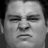

[0]


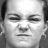

[0]


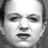

[0]


In [135]:
for i in range(20):
  cv2_imshow(X_test[i] * 255)
  y_pred = best_model(X_test[0:1])  
  print(np.argmax(y_pred, axis=1))



# Confusion Matrix

In [89]:
from sklearn.metrics import confusion_matrix
results = best_model(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
#cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import pandas as pd

label_mapdisgust = ['anger','contempt','disgust','fear','happy','sadness','surprise']


#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )

final_cm = cm_df


final_cm


plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ValueError: ignored

# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle


new_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
final_label = new_label
new_class = 7


#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()